Tasks for the script are the following:

- <font color="LIGHTGRAY">~~Read xlsx file as data + config~~</font>
- System to save experiments with a copy of data and config to the separate folders

- <font color="LIGHTGRAY">~~Normalize on background~~: Convert raw traces (dF) into background-normalized traces (dF/F) using the formula: (dF-mean(background)/mean(background) *100). background = the first 5 datapoints for each trace (defines the background fluorescence for each cell) This is some text! </font>

- <font color="LIGHTGRAY">~~Eliminate the drift.~~ My script uses the moving average subtraction for 20 points at a time. Please use whatever you think is applicable here. Plot result, as above something that I can easily scroll through to make sure that drift elimination  is  appropriate. </font> (This task has been canceled, as we decided not to correct the drift at this point; we may return to it in the future)

- <font color="LIGHTGRAY">~~Clip the baseline~~ to eliminate high spontaneous peaks. Baseline = all the data points prior to the application of the 1st stimulus. Clip at dF/F value = 2SD above the mean baseline. </font>

- <font color="LIGHTGRAY">~~Plot traces.~~  Ideally I want to have a window where I can scroll through the neurons and for each neuron have 3 plots in the same window: dF/F, drift-eliminated, and baseline-clipped. Also, plot vertical lines indicating when the stimulus was applied. This step is primarily for quality control, for me to quickly go through the raw data and make sure that drift elimination and baseline clipping make sense and don’t mess the signal. </font>

- On the plot of the traces shade the area selected for the analysis of each sitmuli (`stim_..._begin` to `stim_..._end`)

- Make it possible to explore the traces interactively

- <font color="LIGHTGRAY">~~Cluster traces~~ using Eucledian or hierechical clustering or any other clustering that you think should be used here. Perform clustering on baseline-clipped and unclipped data.</font>

- <font color="LIGHTGRAY">~~Plot heat map of clustered traces~~.  2 heat maps: 1. Clustered dF/F with unclipped baseline and 2. Clustered dF/F with clipped baseline. I want to visualize both to make sure that baseline clipping is not skewing the data and clustering. </font>

- Add options to order the heatmap by the responses to each stimulus

- Calculate the AUC. For each neuron calculate AUC for the baseline and following each stimulus application. Duration of the baseline as well as intervals between stimuli might slightly vary, even though I try to keep it consistent. Make sure that the AUC is calculated for the equal number of data points for the baseline and each stimulus. Make sure that for the AUC calculation only the positive values are considered. An update to that specification: AUC can be calculated on an un-equal number of samples, but has to be normalized on the number of samples. The frame to which the response has to be calculated is written in the log file.

https://www.mathworks.com/help/matlab/ref/trapz.html

- Plot AUC using box plot. 1 box plot pulling together all AUC values for all neurons. 1st box - baseline, following boxes - stimuli. Set error bars = SD. 

- Determine average and max amplitude following each stimulus. Smooth out the responses to negate the noisy peaks.

- Plot amplitudes using box plot. 1 box plot for avg amplitudes, 1 box plot for max amplitudes. 1st box - baseline, following boxes - stimuli. Set error bars = SD. 

- Determine responce duration???? Not sure how to approach this step. 

- Identify neurons responding to each stimulus. I did it based on the AUC, where I define response as a signal >= (multiplier * SD + mean AUC of baseline ). I want to be able to change the multiplier, making the conditions more or less strict depending on the experiment. Normally (3 >= multiplier >=  5). Save output as a logical array. 

- Plot % responding cells for each stimulus. Perhaps bar graph, or is there a better way to show it?

- Something more complex that could be interesting: Determine the incidence of cells that respond to each stimulus and their overlap.  Basically here I want to visualize how many cells respond to stimulus 1&3 vs cells that respond to only 1 or only 3 ets. Perhaps this could be plotted with Venn diagram.

Other tasks:

- Make analysis more reproducible: save a copy of the data and config, or save hash of the data, or something else. Save each run in a separate folder.

- Test the script with different dataset size, especially regarding the heatmap proportions and visibility

Some thoughts:

- Because ennumeration starts from 0 in Python, it will be very error-prone to think about cells as 1-indexed, which is inevitable if you keep coming back tot he excel file and change things there (like removing some rows, etc). It would be much easier to think about the cell number as starting from 0, and also implement all the functionality, like removing some cells from the analysis, in Python. For example, by having a config variable "ignore-cells" specifing a list of cells to ignore.

- In the excel file you sent me, cells 0 and 52 have the same values -- should I implement a check for such thing? Probably one of them has to be excluded.

In [1]:
import numpy as np
from scipy.io import loadmat

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def normalize_on_background(dF,n_frames_in_background):
    '''
    Normalizes a trace `dF` on the first `n_frames_in_background` samples,
    using the following formula: (dF - MEAN(bg)) / STD(bg) * 100.
    Thus the result is in % of STD deviations from the MEAN of bg.
    
    Returns
    dF_norm : normalized trace
    bg_mean : mean of background period
    bg_std : STD of background period
    '''
    bg_mean = dF.loc[:,:n_frames_in_background].mean(axis=1)
    dF_norm = dF.subtract(bg_mean,axis='rows').divide(bg_mean,axis='rows')*100
    return dF_norm, bg_mean

def clip_backgroud(dF_norm_bg, std_clip=2):
    dF_norm_bg = dF_norm_bg.copy()
    for cell_id, cell_signal in dF_norm_bg.iterrows():
        dF_norm_bg.loc[cell_id,:] = np.clip(
            cell_signal, 
            a_min=cell_signal.mean() - std_clip*cell_signal.std(),
            a_max=cell_signal.mean() + std_clip*cell_signal.std())
    return dF_norm_bg

# from scipy.signal import convolve
# def remove_drift(dF_norm, std_factor=3, n_frames_baseline=30, n_frames_skip=20):
    
#     no_spikes_data = np.zeros_like(dF_norm)
#     movingav = np.zeros_like(dF_norm)
#     result = np.zeros_like(dF_norm)

#     for c in range(cell_num):
        
#         for t in range(n_frames_skip+1):
#             no_spikes_data[c,t] = dF_norm[c,t]
#         threshold = std_factor * np.std(dF_norm[c,:n_frames_baseline])
#         for t in range(n_frames_skip+1, dF_norm.shape[1]):
#             abs1=abs(dF_norm[c,t] - dF_norm[c,t-1])
#             abs2=abs(dF_norm[c,t] - no_spikes_data[c,t-1])
#             if (abs1 > threshold) or (abs2 > threshold):
#                 no_spikes_data[c,t] = np.mean(no_spikes_data[c,(t-4):t])
#             else:
#                 no_spikes_data[c,t] = dF_norm[c,t]

#         movingav[c,:]=convolve(no_spikes_data[c,:],[0.1]*10,mode='same')
#         result[c,:]=dF_norm[c,:]-movingav[c,:]
#     return result

def check_similar_traces(dF, threshold=0.5):
    order = np.argsort(dF.mean(axis=1))
    df_sorted = dF.iloc[order,:]
    for (i1,s1),(i2,s2) in zip(df_sorted.iloc[:-1].iterrows(), 
                               df_sorted.iloc[1:].iterrows()):
        if (s1==s2).mean() > threshold:
            fig, ax = plt.subplots(1,3,figsize=(14,5))
            ax[0].plot(s1)
            ax[0].set_title('Cell number {}'.format(i1))
            ax[1].plot(s2)
            ax[1].set_title('Cell number {}'.format(i2))
            ax[2].plot(s1)
            ax[2].plot(s2)
            ax[2].set_title('Cells {} and {} overlayed'.format(i1,i2))
            raise ValueError('Cells with indexed {} and {} share over {:.0f}% of values'
                             .format(i1,i2,threshold*100))
            
def exclude_cells(dF, ixs_exclude=[]):
    return dF.drop(ixs_exclude, axis='rows')

def eval_str(inp, verbose=False):
    if type(inp)==str:
        try:
            inp = eval(inp)
        except Exception as e:
            if verbose:
                print('Did not execute the string, because:',str(e))
    return inp

In [3]:
# fname = 'data/data_format_example.xlsx'
fname = 'data/S005.xlsx'
dF = pd.read_excel(fname, header=None, usecols='B:ZZZ').T

params = pd.read_excel(fname, sheet_name=1, header=None, usecols='A:B', dtype=object)
# transform parameters from DataFrame to dict
params = params.set_index(0).to_dict()[1]
# execute strings, if possible (helps parse lists and possibly other data types)
params = {k:eval_str(v) for k,v in params.items()}
params

{'baseline_clip_std': 2,
 'exclude_cells_list': [],
 'frame_dur': 3.41,
 'n_frames_in_background': 152,
 'smooting_window': 1,
 'stim_one_bbegin': 220,
 'stim_one_begin': 230,
 'stim_one_bend': 230,
 'stim_one_end': 350,
 'stim_two_bbegin': 400,
 'stim_two_begin': 410,
 'stim_two_bend': 410,
 'stim_two_end': 500}

In [4]:
class StimInformation():
    
    def __init__(self, params):
        self.params = params
        self.extract_stimuli_info()
    
    def extract_stimuli_info(self):
        # get a list of stimuli names, defined in the config
        self.names = ['_'.join(s.split('_')[1:-1]) for s in self.params.keys() if 'stim_' in s]
        self.names = np.unique(self.names)
        self.n = len(self.names)
        
        # get the list of stimuli initiation frames
        self.begins = [params['stim_{}_begin'.format(s)] for s in self.names]
        self.ends = [params['stim_{}_end'.format(s)] for s in self.names]
        
    def __call__(self, name, what):
        return params['stim_{}_{}'.format(name, what)]
    
    def __repr__(self):
        return '(Stim, begin, end): {}'.format(list(zip(self.names, self.begins, self.ends)))
        
stim = StimInformation(params)

In [5]:
stim

(Stim, begin, end): [('one', 230, 350), ('two', 410, 500)]

# User inputs
To be moved to the config file

In [6]:
# # number of frames in baseline
# n_frames_in_background = 5
# # number of stimuli used
# stim_num = len(stims)
# ixs of cells to exclude from analysis
# exclude_cells_list = [52]

In [7]:
dF = exclude_cells(dF, params['exclude_cells_list'])

cell_num = dF.shape[0]
frame_num = dF.shape[1]
time = np.arange(frame_num)*params['frame_dur']/60 # time in min

In [8]:
check_similar_traces(dF, 0.5)

Normalize on background

In [9]:
dF_norm, bg_mean = normalize_on_background(dF, params['n_frames_in_background'])

Eliminate drift

**WIP**: Version of remove drift (old algorithm from Madina's script) for dataframes. Incomplete.

In [10]:
# std_factor=3 
# n_frames_baseline=30 
# n_frames_skip=20
    
# no_spikes_data = pd.DataFrame(0, index=dF_norm.index, columns=dF_norm.columns)
# movingav = pd.DataFrame(0, index=dF_norm.index, columns=dF_norm.columns)
# result = pd.DataFrame(0, index=dF_norm.index, columns=dF_norm.columns)

# no_spikes_data.iloc[:,:n_frames_skip] = dF_norm.loc[:,:n_frames_skip]

# for c in dF_norm.index:

#     threshold = std_factor * np.std(dF_norm.loc[c,:n_frames_baseline])
#     for t in dF_norm.columns[n_frames_skip:]:
# #         import pdb; pdb.set_trace()
#         abs1=abs(dF_norm.loc[c,t] - dF_norm.loc[c,t-1])
#         abs2=abs(dF_norm.loc[c,t] - no_spikes_data.loc[c,t-1])
#         if (abs1 > threshold) or (abs2 > threshold):
#             no_spikes_data.loc[c,t] = np.mean(no_spikes_data.loc[c,(t-4):t])
#         else:
#             no_spikes_data.loc[c,t] = dF_norm.loc[c,t]

#     movingav.loc[c,:]=convolve(no_spikes_data.loc[c,:],[0.1]*10,mode='same')
#     result.loc[c,:]=dF_norm.loc[c,:]-movingav.loc[c,:]

Clip baseline. Baseline = all the data points prior to the application of the 1st stimulus. Clip at dF/F value = 2SD above the mean baseline.

In [11]:
dF_norm_clipped = dF_norm.copy()
dF_norm_clipped.iloc[:,:params['n_frames_in_background']] = \
    clip_backgroud(dF_norm.iloc[:,:params['n_frames_in_background']], params['baseline_clip_std'])

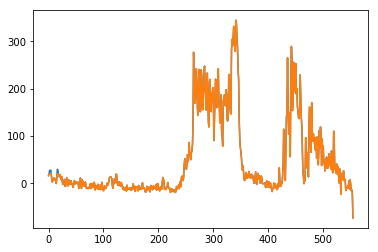

In [12]:
i = 16
plt.plot(dF_norm.loc[i])
plt.plot(dF_norm_clipped.loc[i])

Plot traces: dF_norm, drift-eliminated, and baseline-clipped. +vertical lines to indicate stimulus

In [ ]:
for cell_id, _ in dF.iterrows():
    plt.figure(figsize=(10,8))
    plt.plot(dF_norm.loc[cell_id].values, label='norm')
    plt.plot(dF_norm_clipped.loc[cell_id].values, label='norm, clipped')
    # stimuli lines
    [plt.axvline(stim_frame, color='r', linestyle=':', zorder=0.5) for stim_frame in stim.begins]
    plt.title('Cell {}'.format(cell_id))
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.savefig('img/Cell {}.png'.format(cell_id), dpi=300, bbox_inches='tight')
    plt.close()

Order clusters for the heatmap based on properties 

In [102]:
dataset_for_heatmap = 'norm_clipped'
if dataset_for_heatmap == 'raw':
    dataset = dF
elif dataset_for_heatmap == 'norm':
    dataset = dF_norm
elif dataset_for_heatmap == 'norm_clipped':
    dataset = dF_norm_clipped
    
order_based_on = 'mean'
if order_based_on == 'mean':
    order = np.argsort(dataset.mean(axis=1))
    order = dataset.index[order]

Heat map of clustered traces: dF_norm with unclipped baseline, dF_norm with clipped baseline

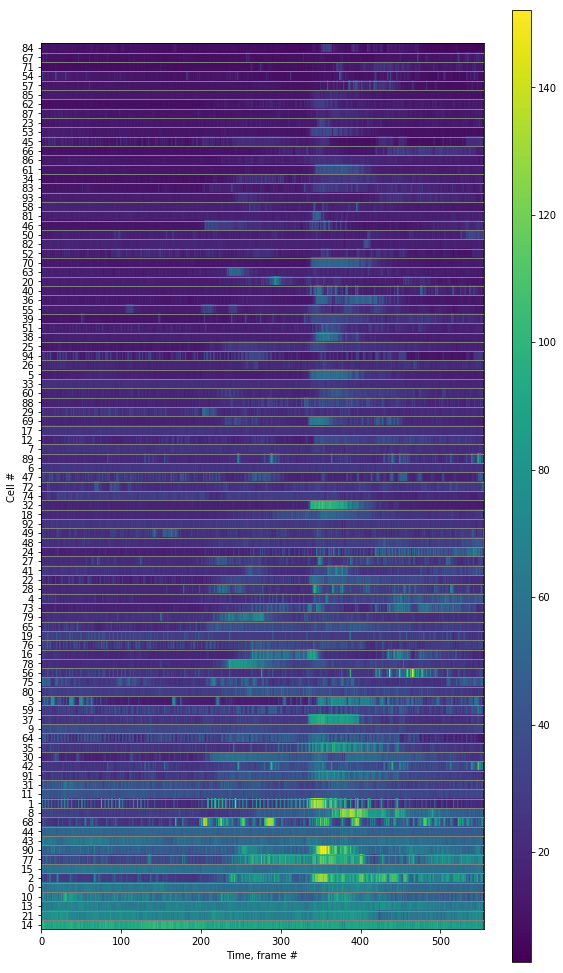

In [103]:
fig, ax = plt.subplots(figsize=(8,14))
im = ax.imshow(dataset.loc[order], aspect=dataset.shape[1]/dataset.shape[0]*2)

ax.set_yticks(np.arange(dataset.shape[0]))
ax.set_yticklabels(order.values)

ax.set_ylabel('Cell #')
ax.set_xlabel('Time, frame #')

## to create gridlines on the y axis, need to create minor ticks and then
## set their length to 0 so that they don't appear as ticks on the axis
ax.set_yticks(np.arange(0.5, dataset.shape[0]-1, 1), minor=True);
ax.grid(which='minor', color='grey', linestyle='-', linewidth=1)
ax.tick_params(which='minor', length=0)

fig.tight_layout()

cbar = ax.figure.colorbar(im, ax=ax, aspect=50)

plt.savefig('img/heatmap_{}.png'.format(dataset_for_heatmap), dpi=300, bbox_inches='tight')

Calculate the AUC. For each neuron calculate AUC for the baseline and following each stimulus application. Duration of the baseline as well as intervals between stimuli might slightly vary, even though I try to keep it consistent. Make sure that the AUC is calculated for the equal number of data points for the baseline and each stimulus. Make sure that for the AUC calculation only the positive values are considered.

In [134]:
stim('one','begin'), stim('one','end')

(230, 350)

In [135]:
350 - 230

120

In [153]:
ix_bl_begin = stim('one','bbegin')
ix_bl_end = stim('one','bend')
bl_mean = dF_norm.iloc[:,ix_bl_begin:ix_bl_end].mean(axis=1)
bl_mean.shape

(95,)

In [158]:
np.subtract(dF_norm.iloc[:,ix_begin:ix_end].values, bl_mean)

ValueError: operands could not be broadcast together with shapes (95,120) (95,) 

In [ ]:
ix_begin = stim('one','begin')
ix_end = stim('one','end')
np.trapz(dF_norm.iloc[:,ix_begin:ix_end].values, 
         dx=params['frame_dur'])/(ix_begin-ix_end)

Plot AUC using box plot. 1 box plot pulling together all AUC values for all neurons. 1st box - baseline, following boxes - stimuli. Set error bars = SD.

Determine average and max amplitude following each stimulus.

Plot amplitudes using box plot. 1 box plot for avg amplitudes, 1 box plot for max amplitudes. 1st box - baseline, following boxes - stimuli. Set error bars = SD.

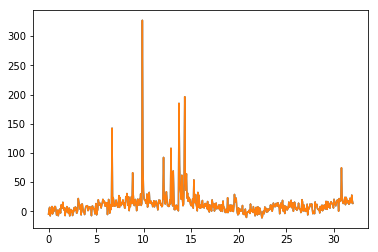

In [8]:
i=0
plt.plot(time,dF_norm[:,i])

# Heatmap
- needs clustering
- adjust to different sized of sample

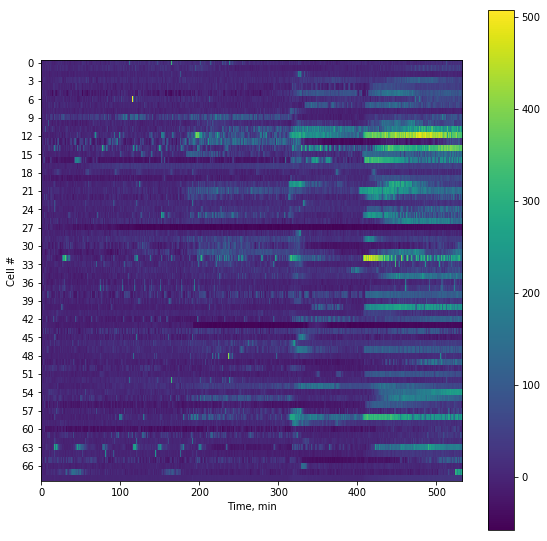

In [79]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(dF_norm.T,aspect=dF_norm.shape[0]/dF_norm.shape[1])
## there will be a maximum 30 yticks, and depending on the number of cells
## a tick will be every 1 or 2 or 3, etc cells 
ax.set_yticks(np.arange(dF_norm.shape[1])[::int(np.ceil(dF_norm.shape[1]/30))])
ax.set_ylabel('Cell #')
ax.set_xlabel('Time, min')
fig.tight_layout()
# ax.grid(which="major", color="w", linestyle='-', linewidth=1)

cbar = ax.figure.colorbar(im, ax=ax)

# Remove drift

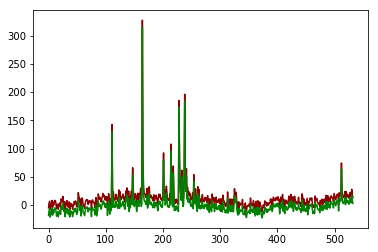

In [10]:
from scipy.signal import detrend, convolve

plt.plot(dF_norm[:,i],c='darkred')
plt.plot(detrend(dF_norm[:,i]),c='g')

0.2770083102493075

In [192]:
dF_norm.shape

(533, 54)

In [80]:
result = remove_drift(dF_norm)

0


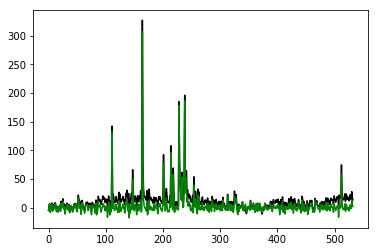

1


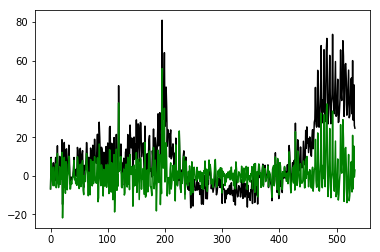

2


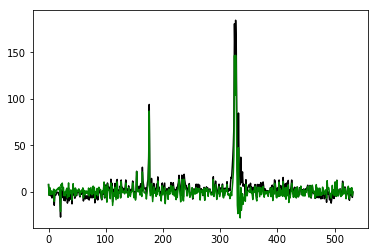

3


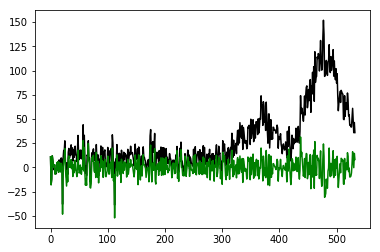

4


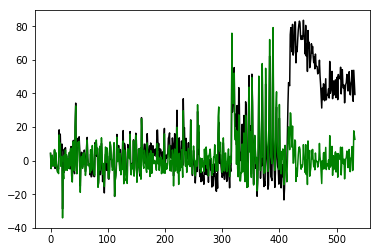

5


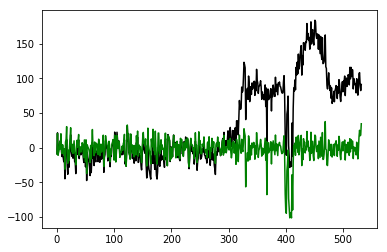

6


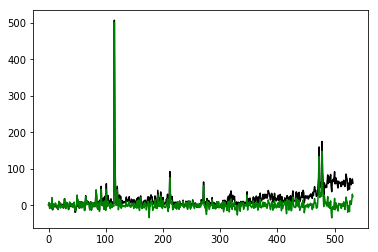

7


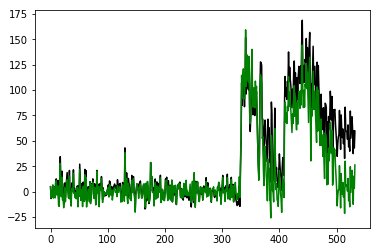

8


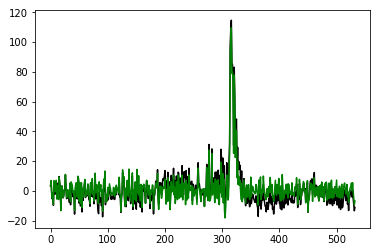

9


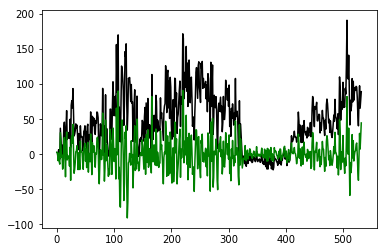

10


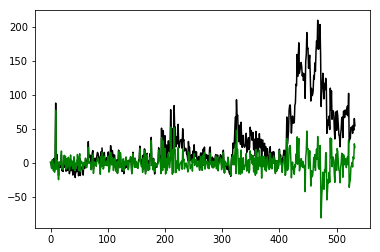

11


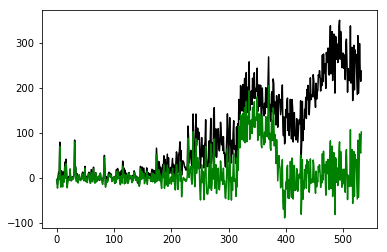

12


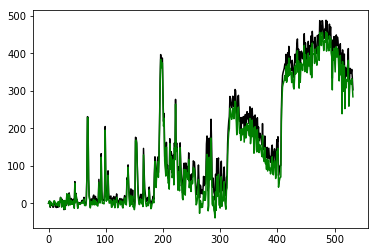

13


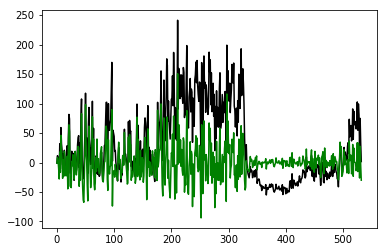

14


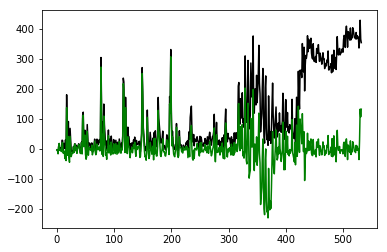

15


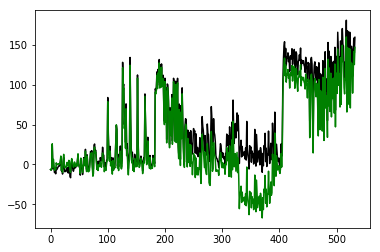

16


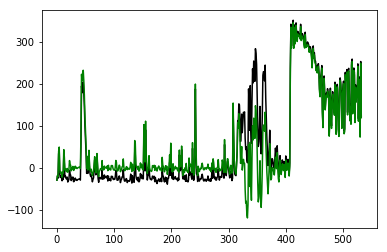

17


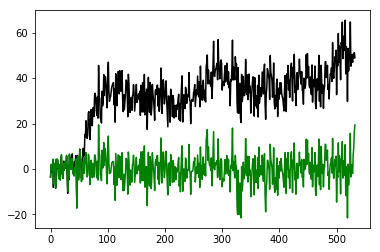

18


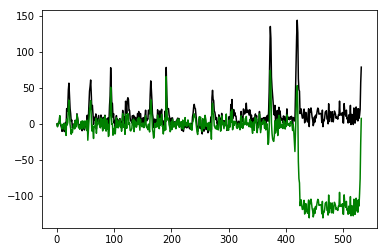

19


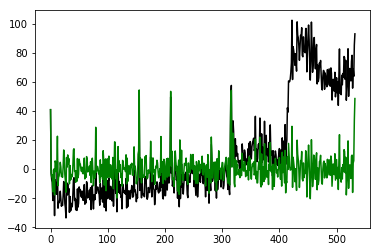

In [81]:
for i in range(20):
    print(i)
    plt.plot(dF_norm[:,i],c='k')
#     plt.plot(NoDriftdata[:,i],c='r')
#     plt.plot(minus_moving_average[:,i],'b')
#     plt.plot(transresult1[:,i],c='b')
    plt.plot(result[:,i],c='g')
    # plt.plot(detrend(dF_norm[:,i]),c='g')
    plt.show()

<IPython.core.display.Javascript object>


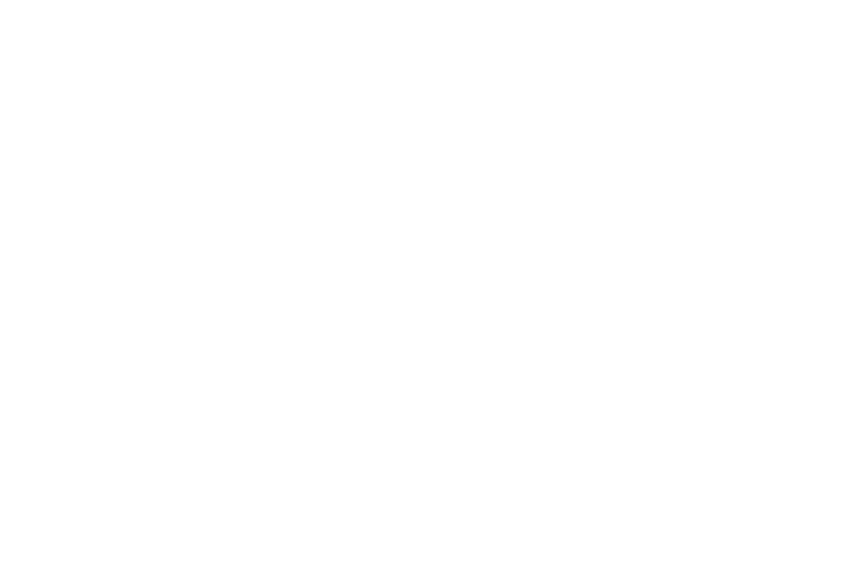

NameError: name 'butter_highpass_filter' is not defined

<IPython.core.display.Javascript object>


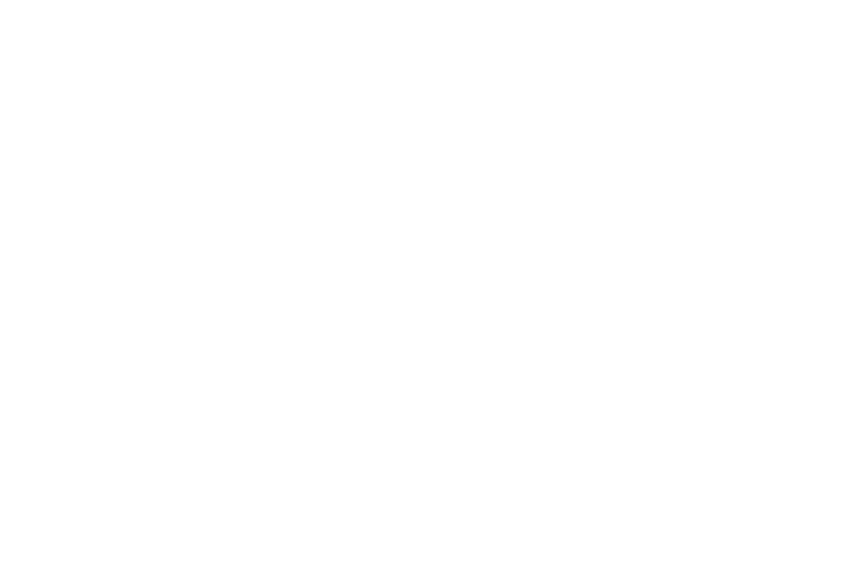

In [34]:
%matplotlib notebook
from scipy.signal import freqz
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1/params['frame_dur']
lowcut = 0.005

x = dF_norm[:,i]
t = time
T=t[-1]
plt.figure(2,figsize=(12,8))
plt.clf()
plt.plot(t, x, label='Noisy signal')

y = butter_highpass_filter(x, lowcut, fs, order=1)
plt.plot(t, y, label='Filtered',zorder=0.5,c='r')
plt.plot(t, result[i,:],c='green',label='Old',zorder=0.1)
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()


In [76]:
dF_norm_bg = dF_norm[:n_frames_in_baseline]

In [83]:
dF_norm_bg

array([[-17.67138842,  -5.27674629,   9.66431247, ...,  -0.78356012,
         -5.75927956,  -7.43786808],
       [-10.65413551,  -3.66189191,   6.79062009, ...,  -0.69449689,
          0.30771961, -17.02140138],
       [-16.2357363 , -10.30866821,   6.97583092, ...,  -6.33516821,
         -3.9262713 ,  -9.01318123],
       ...,
       [-18.79844243,  -1.85967874, -12.72280398, ...,  -1.9908617 ,
          2.56240583,   2.52246923],
       [-13.05583393,   3.93060022,  -5.24418526, ...,   1.04718409,
         40.09174395,   1.5781893 ],
       [-19.03324534,  -0.91396291, -15.54580708, ...,   0.1763436 ,
          1.15107552,   3.34417436]])

In [84]:
mask_outliers = dF_norm_bg>(bg_mean+2*bg_std)
for cell in range(dF_norm_bg.shape[1]):
    dF_norm_bg[mask_outliers[:,cell],cell] = bg_mean[cell]+2*bg_std[cell]

In [68]:
(dF_F_raw[:n_frames_in_baseline]>bg_mean).shape

(161, 54)

<IPython.core.display.Javascript object>


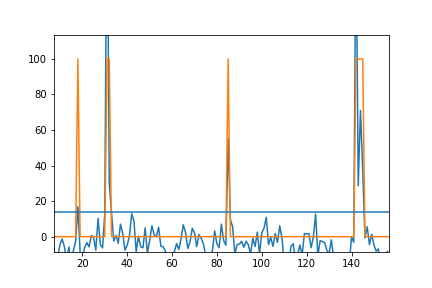

In [72]:
i=3
plt.plot(dF_F_raw[:,i])
plt.plot((dF_F_raw[:n_frames_in_baseline]>bg_mean)[:,i]*100)
plt.axhline(bg_mean[i])
plt.show()

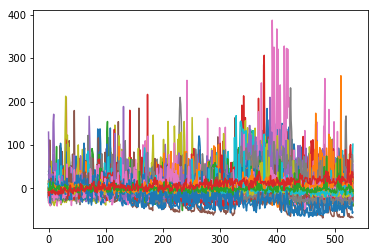

In [35]:
plt.plot(dF_F_raw)

<IPython.core.display.Javascript object>


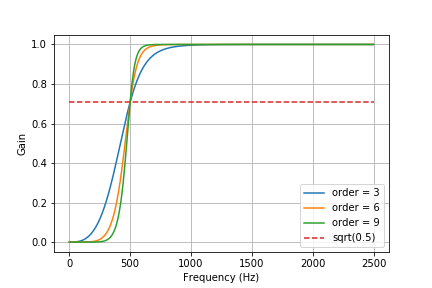

D:\Programs\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:44: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


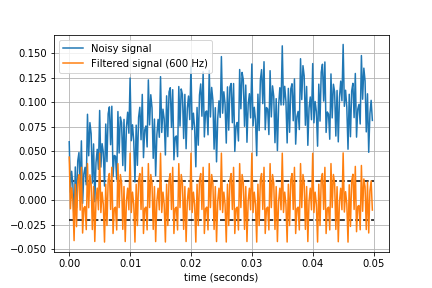

In [203]:
from scipy.signal import butter, lfilter, filtfilt

def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, [low], btype='highpass')
    return b, a


def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    y = lfilter(b, a, y[::-1])[::-1]
    return y


def run():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_highpass(lowcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_highpass_filter(x, lowcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()


run()